In [1]:
import os

In [2]:
%pwd

'f:\\DATA-SCIENCE\\Chest-Cancer-Prediction\\research'

In [3]:
os.chdir('../')

In [4]:
%pwd

'f:\\DATA-SCIENCE\\Chest-Cancer-Prediction'

##  Adding mlfow tracking uri

In [5]:
os.environ["MLFLOW_TRACKING_URI"]="https://dagshub.com/dannychemm123/Chest-Cancer-Prediction.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"]="dannychemm123"
os.environ["MLFLOW_TRACKING_PASSWORD"]="1697b102f989a25d5e4761023b575cb8072ca820"

## Loading the model 

In [5]:
import tensorflow as tf

model = tf.keras.models.load_model("artifacts/training/model.h5")

## Creating entity

In [7]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen =True)
class EvaluationConfig:
    path_of_model : Path
    training_data: Path
    all_params: dict
    mlflow_uri: str
    params_image_size: list
    params_batch_size: int
    

## Creating Configuration Manager

In [6]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directory

class ConfigurationManager:
    def __init__(self,
                 config_filepath = CONFIG_FILE_PATH,
                 params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        
        create_directory([self.config.artifacts_root])
        
    def get_evaluation_config(self)->EvaluationConfig:
        eval_config = EvaluationConfig(
            path_of_model = 'artifacts/training/model.h5',
            training_data = 'artifacts/data_ingestion/Chest-CT Scan Images',
            mlflow_uri = 'https://dagshub.com/dannychemm123/Chest-Cancer-Prediction.mlflow',
            all_params = self.params,
            params_image_size = self.params.IMAGE_SIZE,
            params_batch_size = self.params.BATCH_SIZE
            
        )
        return eval_config


NameError: name 'EvaluationConfig' is not defined

## Creating components

In [8]:
import tensorflow as tf
import mlflow
import mlflow.keras
from pathlib import Path
from urllib.parse import urlparse
from cnnClassifier.utils.common import save_json
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from cnnClassifier.entity.config_entity import EvaluationConfig
class Evaluation:
    def __init__(self,config: EvaluationConfig):
        self.config = config
        
    # def get_base_model(self):
    #     self.model = tf.keras.models.load_model(
    #         self.config.updated_base_model_path
        #)
    def _valid_generator(self):
        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split = 0.30
        )
        
        dataflow_kwargs = dict(
            target_size = self.config.params_image_size[:-1],
            batch_size = self.config.params_batch_size,
            interpolation = 'bilinear'
            
        )
        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )
        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory = self.config.training_data,
            subset='validation',
            shuffle=False,
            **dataflow_kwargs
        )
    @staticmethod    
    def load_model(path:Path)->tf.keras.Model:
        return tf.keras.models.load_model(path)
    
    # def evaluation(self):
    #     self.model = self.load_model(self.config.path_of_model)
    #     self._valid_generator()
    #     self.score = model.evaluate(self.valid_generator)
    #     self.save_score()
    
    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = self.model.evaluate(self.valid_generator)
        
        # Predict the labels for the validation set
        predictions = self.model.predict(self.valid_generator)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = self.valid_generator.classes
        class_labels = list(self.valid_generator.class_indices.keys())

        # Compute the confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)

        # Plot the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Optionally, print the classification report
        print(classification_report(true_classes, predicted_classes, target_names=class_labels))

        self.save_score()
        
    def save_score(self):
        scores = {"loss": self.score[0],"accuracy": self.score[1]}
        save_json(path = Path('score.json'),data=scores)
        
    # def log_into_mlflow(self):
    #     mlflow.set_registry_uri(self.config.mlflow_uri)
    #     tracking_uri_type_store = urlparse(mlflow.get_artifact_uri()).scheme
        
    #     with mlflow.start_run(nested=True):
    #         mlflow.log_params(self.config.all_params)
    #         mlflow.log_metrics(
    #             {"loss": self.score[0],"acuracy": self.score[1]}
    #         )
    #         #mlflow.end_run()
        
           
            
            # # Model registry does not work with file socre
            # if tracking_uri_type_store !='file':
                
            #     mlflow.keras.log_model(self.model,"model",registered_model_name="VGG16Model")
            # else:
            #     mlflow.keras.log_model(self.model,'model')
                

[2024-03-26 12:46:51,115: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-03-26 12:46:51,188: INFO: common: yaml file: params.yaml loaded successfully]
[2024-03-26 12:46:51,194: INFO: common: created directory at: artifacts]


Found 102 images belonging to 2 classes.
7/7 [==============================] - 38s 5s/step


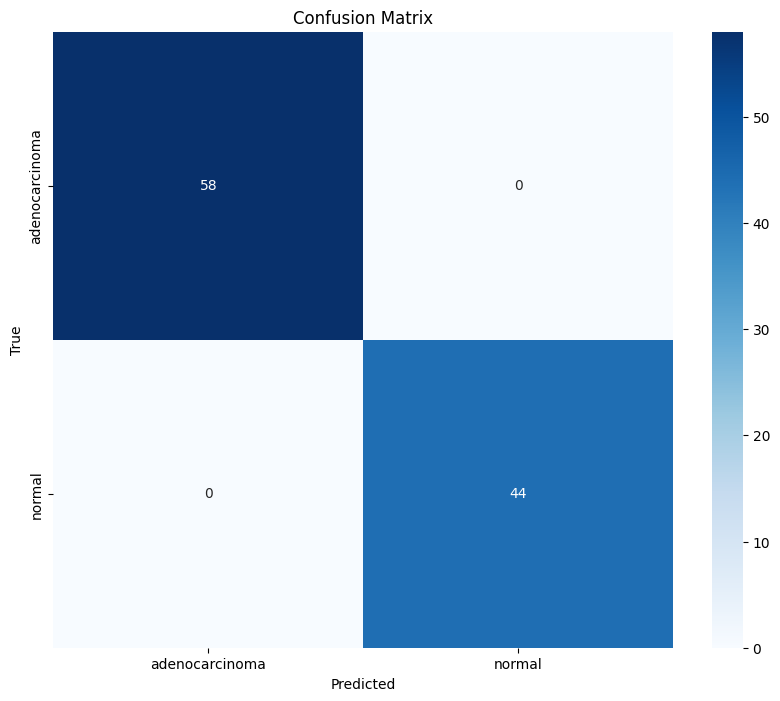

                precision    recall  f1-score   support

adenocarcinoma       1.00      1.00      1.00        58
        normal       1.00      1.00      1.00        44

      accuracy                           1.00       102
     macro avg       1.00      1.00      1.00       102
  weighted avg       1.00      1.00      1.00       102

[2024-03-26 12:48:17,647: INFO: common: json file saved at: score.json]


In [10]:
from cnnClassifier.config.configuration import ConfigurationManager
try:
    config = ConfigurationManager()
    eval_config = config.get_evaluation_config()
    evaluation = Evaluation(eval_config)
    evaluation.evaluation()
    #evaluation.log_into_mlflow()
    
except Exception as e:
    raise e
